# MATH3976 Project: SimpleCircuits.jl

David Rapisarda

SID: 440429320

Note: this has two dependencies - [DataStructures.jl](https://github.com/JuliaLang/DataStructures.jl) and [Sundials.jl](https://github.com/JuliaLang/Sundials.jl). 

In [1]:
include("SimpleCircuits.jl")
using SimpleCircuits
using PyPlot
versioninfo()

Julia Version 0.4.5
Commit 2ac304d (2016-03-18 00:58 UTC)
Platform Info:
  System: Linux (x86_64-linux-gnu)
  CPU: Intel(R) Core(TM) i5-4670 CPU @ 3.40GHz
  WORD_SIZE: 64
  BLAS: libopenblas (NO_LAPACK NO_LAPACKE DYNAMIC_ARCH NO_AFFINITY Haswell)
  LAPACK: liblapack.so.3
  LIBM: libopenlibm
  LLVM: libLLVM-3.3


This document is split into three parts: in the first, the implementation details of the simulator are covered. In the second part, some examples of the simulator in use are shown. In the last part, the originality of the project in the context of existing research is considered, and some avenues for further work are discussed.

## Part 1: Implementation Details

The general approach taken here to solving circuits is to generate a system of equations of the form:

$$ \vec{F}(\vec{v}, \vec{I}) = 0 $$

where $\vec{v}$ is the vector of node voltages of the circuit, and $\vec{I}$ is the vector of "dummy" currents - currents through components that do not specify a DC IV relation (more on that later). The generated system should have the same number of equations as variables.

From here on, the system will be written as $\vec{F}(\vec{x})$ with $\vec{x} = [\vec{v}; \: \vec{I}]$.

To solve the system efficiently, we also need to generate an expression for the Jacobian matrix of the above system:

## Part 2: Examples

### Example 1: Voltage Divider

<img src="img/example1.png" />

This is the simplest example of any interest: two resistors connected in series, excited by a DC voltage source. 

In [2]:
circ = Circuit()
r1 = Resistor(5e+3)
r2 = Resistor(10e+3)
vin = DCVoltageSource(5.)
connect!(circ, vin.pLow, circ.gnd)
connect!(circ, vin.pHigh, r1.p1)
connect!(circ, r1.p2, r2.p1, "Vout")
connect!(circ, r2.p2, circ.gnd)

cop = op(circ)

Node voltages: 
3.333333333333333 <==> Vout
0.0 <==> GND
5.0 <==> node 1
DCVoltageSource currents: 
0.0003333333333333334 <==> SimpleCircuits.DCVoltageSource("",5.0,port pHigh on a DCVoltageSource connected to node "node 1",port pLow on a DCVoltageSource connected to node "GND")


See what happens when varing the value of R1:

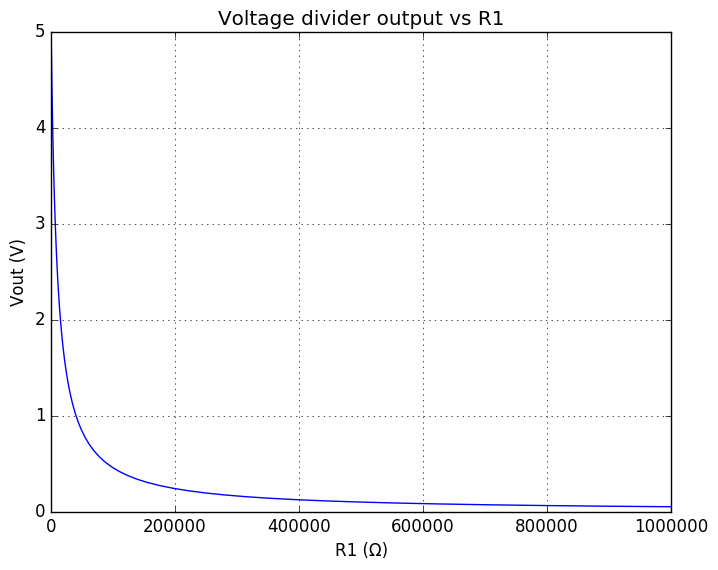

In [3]:
# change the resistance of r1 to a parameter
r1.R = :R
params = Parameters(:R => 1.)
R_range = logspace(1., 6., 100)

# compute the operating point for all values of this parameter
cop = dc_sweep(circ, :R, R_range, params)

grid(b=true, which="major")
title("Voltage divider output vs R1")
xlabel("R1 (Ω)")
ylabel("Vout (V)")
plot(R_range, cop[r1.p2]);

### Example 2: Simple diode circuit

<img src="img/example2.png" />

Linear circuit analysis is not so interesting, since Thevenin's theorem states that for any linear circuit there exists an equivalent circuit, with one voltage source and one resistor, which appears exactly the same as the original circuit, when looking at two nodes - so now let's examine a simple non-linear circuit. 

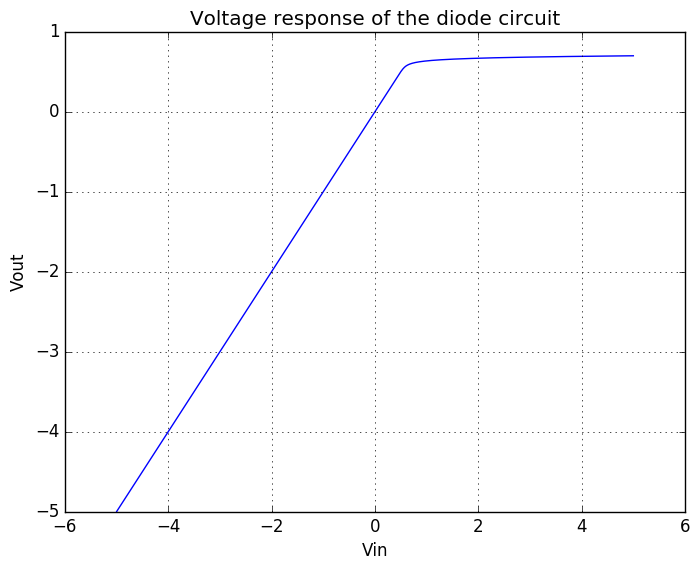

In [4]:
circ = Circuit()
r1 = Resistor(1e+3)
d1 = Diode() # using the default values for a diode

# we will be sweeping over the input voltage
vin = DCVoltageSource(:V)

connect!(circ, vin.pLow, circ.gnd)
connect!(circ, vin.pHigh, r1.p1)
connect!(circ, r1.p2, d1.pIn)
connect!(circ, d1.pOut, circ.gnd)

# default value for Vin - it will be overridden when we sweep anyway
params = Parameters(:V => 5.)

V_range = -5.:0.01:5.
cop = dc_sweep(circ, :V, V_range, params)

# plot the voltage on the diode
grid(b=true, which="major")
title("Voltage response of the diode circuit")
xlabel("Vin")
ylabel("Vout")
plot(V_range, cop[r1.p2]);

We can see that the diode in this case acts like a voltage "limiter" at one end - in the limited region, the diode is acting like a short circuit, plus a constant ~$0.7 \textrm{ V}$ voltage drop. This can be extended to form a useful circuit ...

### Example 3: Voltage limiter

<img src="img/example3.png" />

This works the same way as the above circuit does - but now we have two diodes in parallel, facing opposite directions - so the voltage is limited on both sides. For a more interesting result, let's put two diodes in series in one branch, so that the limit on one side should be twice as large as the other side.

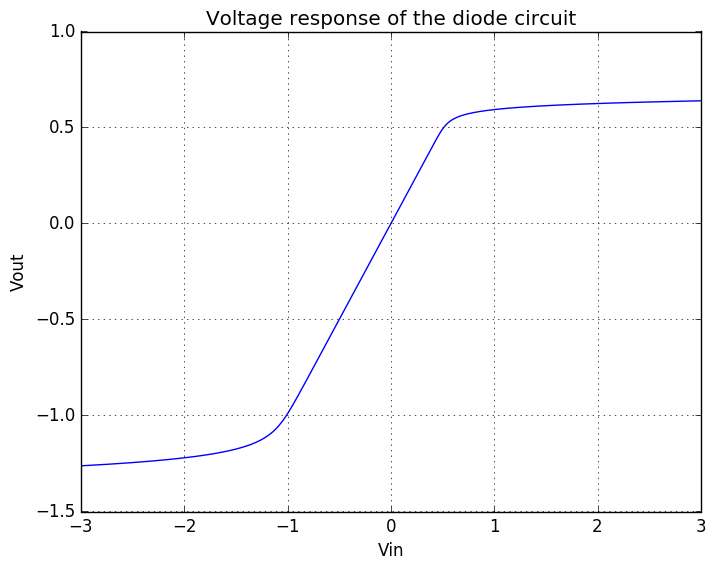

In [5]:
circ = Circuit()
vin = DCVoltageSource(:V)
r1 = Resistor(5e+3)

# the default parameters are reasonable - we could investigate variations in the ideality factor, temperuture,
# saturation current, etc
d1 = Diode()
d2 = Diode()
d3 = Diode()

connect!(circ, vin.pLow, circ.gnd)
connect!(circ, vin.pHigh, r1.p1)

# connect the first (single) diode branch
connect!(circ, r1.p2, d1.pIn)
connect!(circ, d1.pOut, circ.gnd)

# connect the second (double) diode branch
connect!(circ, r1.p2, d2.pOut)
connect!(circ, d2.pIn, d3.pOut)
connect!(circ, d3.pIn, circ.gnd)

V_range = -3.:0.01:3.
cop = dc_sweep(circ, :V, V_range, params)

# plot the voltage on the diode
grid(b=true, which="major")
title("Voltage response of the diode circuit")
xlabel("Vin")
ylabel("Vout")
plot(V_range, cop[r1.p2]);

Let's run transient analysis on the above circuit, with a sinusoidal input (note that because there's no components that introduce time derivatives, this is equivalent to a DC sweep):

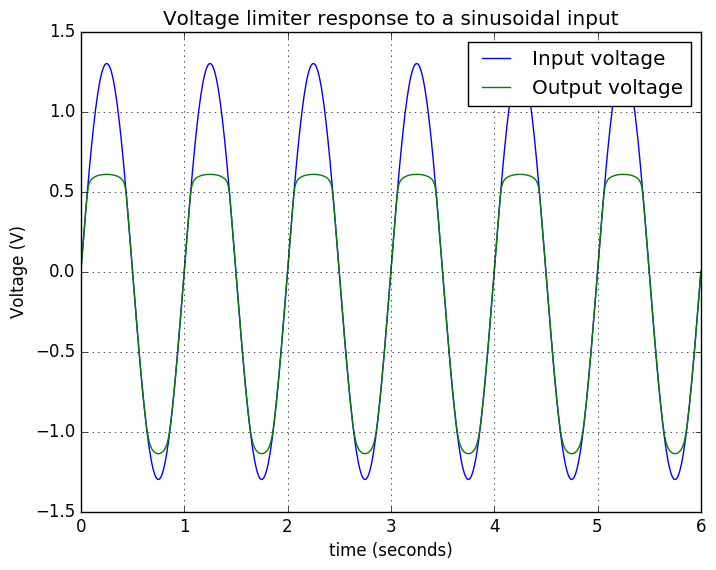

In [6]:
# we have to replace the DCVoltageSource with a VoltageSource - probably a poor design decision there
# disconnect both it's ports
disconnect!(circ, vin.pLow)
disconnect!(circ, vin.pHigh)

# replace it
vin = VoltageSource(:(1.3*sin(2pi * t)))
connect!(circ, vin.pLow, circ.gnd)
connect!(circ, vin.pHigh, r1.p1)

# do the analysis
trange = 0.:0.01:6
cop = trans_exp(circ, trange)

grid(b=true, which="major")
title("Voltage limiter response to a sinusoidal input")
xlabel("time (seconds)")
ylabel("Voltage (V)")
plot(trange, cop[vin.pHigh])
plot(trange, cop[r1.p2])
legend(["Input voltage", "Output voltage"]);

### Example 4: Low pass voltage limiter

Now we can extend the above circuit to one that has state by adding a capacitor in parallel with the diodes, forming a low pass filter.

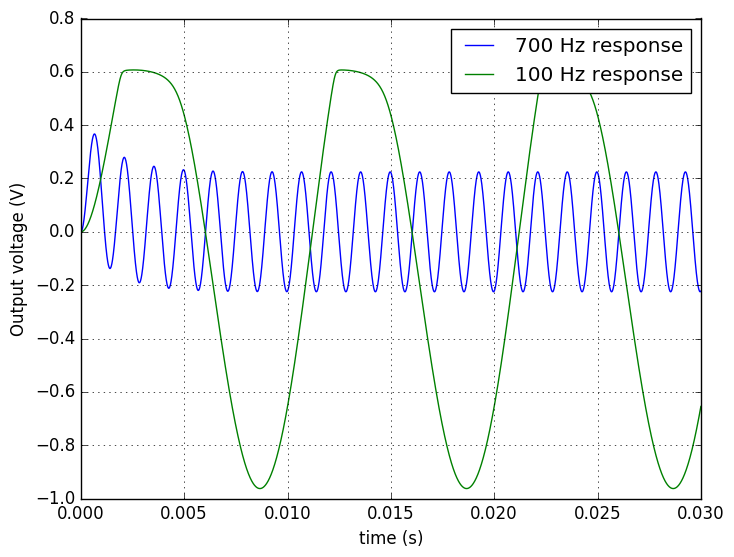

In [7]:
c1 = Capacitor(3e-7)

# connect it across the diode branches
connect!(circ, c1.p1, r1.p2)
connect!(circ, c1.p2, circ.gnd)

# set the input voltage frequency to 700 Hz
f = 0.7e+3
vin.V = :(1.5*sin(2pi*$(f)*t))

# set a small range as appropriate for a high frequency
trange = 0.:0.00001:0.03
cop = trans_exp(circ, trange)

grid(b=true, which="major")
plot(trange, cop[r1.p2])

# now do it again, for a lower frequency
f = 0.1e+3
vin.V = :(1.3*sin(2pi*$(f)*t))

cop = trans(circ, trange)
plot(trange, cop[r1.p2])

legend(["700 Hz response", "100 Hz response"])
xlabel("time (s)")
ylabel("Output voltage (V)");

### Example 5: Simple NPN BJT circuit

In [8]:
circ = Circuit()
vcc = DCVoltageSource(10.)
rc = Resistor(100.)
rb1 = Resistor(30e+3)
rb2 = Resistor(10e+3)
q1 = NPN(βf=100.)

connect!(circ, vcc.pLow, circ.gnd)
connect!(circ, vcc.pHigh, rc.p1, "VCC")
connect!(circ, rc.p2, q1.pC, "Vout")
connect!(circ, rb1.p1, vcc.pHigh)
connect!(circ, rb1.p2, q1.pB, "VB")
connect!(circ, rb2.p1, rb1.p2)
connect!(circ, rb2.p2, circ.gnd)
connect!(circ, q1.pE, circ.gnd)

cop = op(circ)

Node voltages: 
7.442006987378844 <==> Vout
10.0 <==> VCC
0.0 <==> GND
0.5815052443182216 <==> VB
DCVoltageSource currents: 
0.025893879951400956 <==> SimpleCircuits.DCVoltageSource("",10.0,port pHigh on a DCVoltageSource connected to node "VCC",port pLow on a DCVoltageSource connected to node "GND")


What happens to the circuit as $\beta_f$, the ratio between collector and base currents in forward active mode, varies?

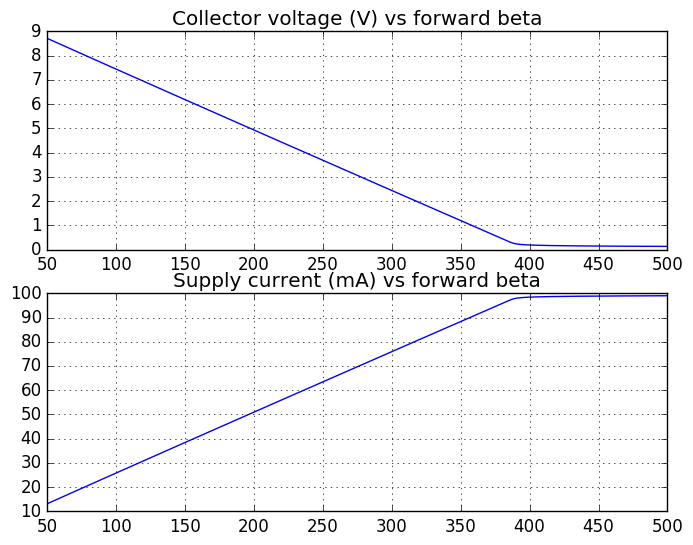

In [9]:
# what happens to the node voltages as the forward Ic/Ib ratio parameter (βf) varies?
q1.βf = :βf

params = Parameters(:βf => 50.)

βf_range = 50.:1.:500.
cop = dc_sweep(circ, :βf, βf_range, params)

# plot the output voltage, and also plot the current through VCC
subplot(2, 1, 1)
grid(b=true, which="major")
title("Collector voltage (V) vs forward beta")
plot(βf_range, cop[q1.pC])
subplot(2, 1, 2)
title("Supply current (mA) vs forward beta")
grid(b=true, which="major")
plot(βf_range, 1e+3 * cop[vcc]);

The transistor is in the forward active region up until $\beta_f = 400$, beyond which the transistor is saturated.

### Example 6: NPN BJT circuit with coupling capacitors and small signal input

In [10]:
# first, change βf back to a number
q1.βf = 100.

# use the previous circuit, and add in the following:
#  - a capacitively coupled input signal on the base
#  - a capacitively coupled load on the collector

# input coupling capacitor
cc_in = Capacitor(1e-6)
cc_out = Capacitor(1e-6)

# input source
f = 200.
vin = VoltageSource(:(0.04*sin(2π*$(f)*t)))

# output load
rl = Resistor(10e+3)

# connect the input
# add a small resistor here, for stability
rs = Resistor(100.)
connect!(circ, cc_in.p2, q1.pB)
connect!(circ, cc_in.p1, rs.p2)
connect!(circ, vin.pHigh, rs.p1)
connect!(circ, vin.pLow, circ.gnd)

# connect the output
connect!(circ, cc_out.p1, q1.pC)
connect!(circ, cc_out.p2, rl.p1, "Vload")
connect!(circ, rl.p2, circ.gnd);

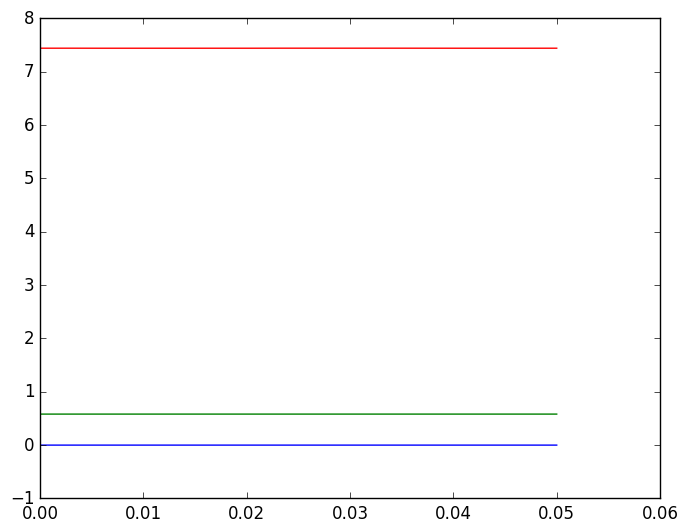

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7ff908d42b38>

In [11]:
f = 200.
vin.V = :(0.00001*sin(2π*$(f)*t))

cc_in.C = 1.

# run transient analysis
trange = 0.:0.000004:0.05
cop_trans = trans_exp(circ, trange)

#plot(trange, cop_trans[rl.p1])
plot(trange, cop_trans[vin.pHigh])
plot(trange, cop_trans[q1.pB])
plot(trange, cop_trans[q1.pC]);

# the result is obviously not correct - the Sundials IDA solver is failing here
# i can't figure out a way to get it to take into account my Jacobian

We can isolate the above issue to a simpler circuit, without a transistor:

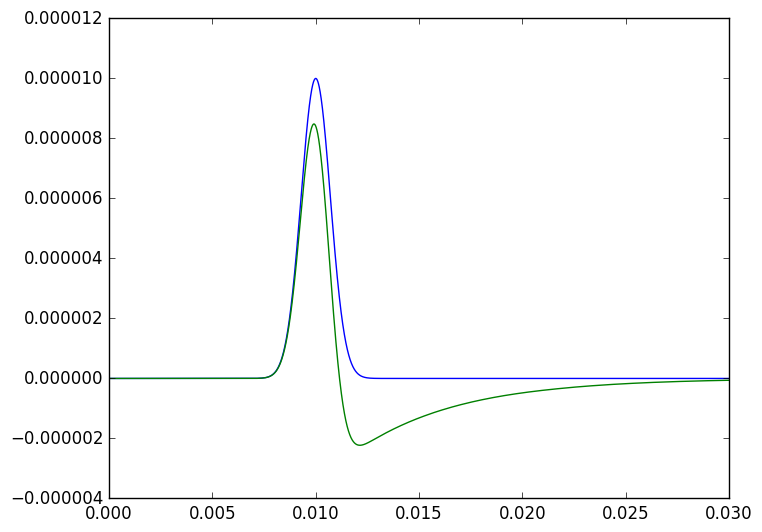

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7ff908e53748>

In [12]:
circ = Circuit()
vcc = DCVoltageSource(10.)
r1 = Resistor(10e+3)
r2 = Resistor(10e+3)
c1 = Capacitor(1e-6)
vin = VoltageSource(:(0.00001.*exp(-1000000.*(t-0.01).^2)))

connect!(circ, vcc.pLow, circ.gnd)
connect!(circ, vcc.pHigh, r1.p1, "Vcc")
connect!(circ, r1.p2, r2.p1, "Vout")
connect!(circ, r2.p2, circ.gnd)
connect!(circ, vin.pLow, circ.gnd)
connect!(circ, vin.pHigh, c1.p1, "Vin")
connect!(circ, c1.p2, r1.p2)

op(circ)

trange = 0.:0.000001:0.03
cop = trans_exp(circ, trange)
plot(trange, cop[vin.pHigh])
plot(trange, cop[r1.p2] - 5.)

In [13]:
cop

Node voltages: 
[0.0,3.79523e-49,3.87192e-49,3.9509e-49,4.02999e-49,4.11361e-49,4.19771e-49,4.28181e-49,4.3659e-49,4.45889e-49  …  -1.74181e-20,-1.74236e-20,-1.74291e-20,-1.74346e-20,-1.74401e-20,-1.74456e-20,-1.7451e-20,-1.74564e-20,-1.74618e-20,-1.74672e-20] <==> Vin
[5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0  …  5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0] <==> Vout
[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0] <==> GND
[10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0  …  10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0] <==> Vcc
DCVoltageSource currents: 
[0.0,5.68325e-57,2.30004e-56,5.81465e-56,9.41809e-56,1.66456e-55,2.4258e-55,3.18703e-55,3.94827e-55,5.4667e-55  …  -1.21795e-11,-1.2177e-11,-1.21744e-11,-1.21719e-11,-1.21693e-11,-1.21668e-11,-1.21643e-11,-1.21617e-11,-1.21592e-11,-1.21567e-11] <==> SimpleCircuits.VoltageSource("",:(1.0e-5 .* exp(-1000000 .* (t - 0.01) .^ 2)),port pHigh on a VoltageSource connected to node "Vin",port pLow on a 

In [14]:
# i think the instability is an initial condition problem
sm = gen_sym_map(circ)
dtsm = SimpleCircuits.gen_dt_sym_map(sm)
gen_sys_exprs(sm, circ, dtsm)

6-element Array{Any,1}:
 :(x[1])                                                                                  
 :((0.0 + -1.0 * x[5]) + (x[2] - x[3]) / 10000.0)                                         
 :(((0.0 + (x[3] - x[2]) / 10000.0) + (x[3] - x[1]) / 10000.0) + 1.0e-6 * (xp[3] - xp[4]))
 :((0.0 + -1.0 * x[6]) + 1.0e-6 * (xp[4] - xp[3]))                                        
 :((x[2] - x[1]) - 10.0)                                                                  
 :((x[4] - x[1]) - 1.0e-5 .* exp(-1000000 .* (t - 0.01) .^ 2))                            

In [15]:
sm

DataStructures.OrderedDict{Any,Any} with 6 entries:
  Node: GND…               => :(x[1])
  Node: Vcc…               => :(x[2])
  Node: Vout…              => :(x[3])
  Node: Vin…               => :(x[4])
  SimpleCircuits.DCVoltag… => :(x[5])
  SimpleCircuits.VoltageS… => :(x[6])

In [16]:
op(circ)

Node voltages: 
0.0 <==> Vin
5.0 <==> Vout
0.0 <==> GND
10.0 <==> Vcc
DCVoltageSource currents: 
0.0 <==> SimpleCircuits.VoltageSource("",:(1.0e-5 .* exp(-1000000 .* (t - 0.01) .^ 2)),port pHigh on a VoltageSource connected to node "Vin",port pLow on a VoltageSource connected to node "GND")
0.0005 <==> SimpleCircuits.DCVoltageSource("",10.0,port pHigh on a DCVoltageSource connected to node "Vcc",port pLow on a DCVoltageSource connected to node "GND")


## Part 3: Further Work

### General interface cleanup/organization

The idea of this project is to implement a programmable circuit simulator that's easy and intuitive to use - there's a lot of room for improvement here. For example, the 

### Improvements to the way 'parameters' are handled

### Improvements to the Newton-Raphson implementation

### Improvements to transient analysis

### Implement MOSFETS

### 